# Learn from Outputs — Supervision Matching


This notebook documents the supervision matcher pipeline so you can re-run every step and inspect the outputs.

**Run everything**
- Choose `Kernel → Restart & Run All` to regenerate synthetic data, retrain the model, and refresh the diagnostics.
- Every code cell ultimately calls `python supervision_tool.py generate build train score`, keeping the notebook reproducible.

**Sections**
1. Hard filters (exact state + license matching).
2. Availability similarity model (TF-IDF + cosine).
3. Capacity-aware greedy assignment.
4. Diagnostics & next steps.



## Run the full pipeline from here

This cell runs the CLI so the notebook stays in sync with the latest synthetic data and model artifacts.


In [9]:
!python supervision_tool.py generate build train score


=== generate ===
Wrote synthetic supervisors & associates.
done.

=== build ===
Wrote pairs -> /home/connor/Sophias_Mom/ai_matching/Supervision_HistoricalPairs_SYNTH.csv
done.

=== train ===
=== Validation Report ===
/home/connor/Sophias_Mom/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/connor/Sophias_Mom/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/connor/Sophias_Mom/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: Und

## 0) Load generated artifacts

Inspect the fresh CSVs and model bundle produced by the pipeline run above.


In [10]:

from pathlib import Path
import pandas as pd

pairs_csv = Path('Supervision_HistoricalPairs_SYNTH.csv')
matches_csv = Path('supervision_matches.csv')
unassigned_csv = Path('associates_unassigned.csv')
model_path = Path('supervision_pair_model.joblib')

print('Found files:')
for p in [pairs_csv, matches_csv, unassigned_csv, model_path]:
    print(' -', p.resolve(), 'exists?' , p.exists())

pairs = pd.read_csv(pairs_csv) if pairs_csv.exists() else None
matches = pd.read_csv(matches_csv) if matches_csv.exists() else None
unassigned = pd.read_csv(unassigned_csv) if unassigned_csv.exists() else None

if pairs is not None:
    display(pairs.head())
if matches is not None:
    display(matches.head())
if unassigned is not None:
    display(unassigned.head())


Found files:
 - /home/connor/Sophias_Mom/ai_matching/Supervision_HistoricalPairs_SYNTH.csv exists? True
 - /home/connor/Sophias_Mom/ai_matching/supervision_matches.csv exists? True
 - /home/connor/Sophias_Mom/ai_matching/associates_unassigned.csv exists? True
 - /home/connor/Sophias_Mom/ai_matching/supervision_pair_model.joblib exists? True


,assoc_idx,sup_idx,Associate,Associate Email,Associate State,Associate License,Associate Availability,Supervisor,Supervisor Email,Supervisor State,Who can you supervise?,Supervisor Availability,Capacity,AvailabilityOverlap,AvailabilityScore,Label,Reason
0,0,22,Dakota Wilson,dakota.wilson@sample.org,VA,Social Worker,"Monday 10:30 AM, Tuesday 11:00 AM, Tuesday 12:...",Casey Bennett,casey.bennett@example.com,VA,"Social Worker, Marriage and Family Therapist","Monday 12:00 PM, Monday 3:30 PM, Tuesday 10:00...",4,1,0.641311,1,good_match
1,4,28,Sam Martinez,sam.martinez@mail.net,IA,Marriage and Family Therapist,"Monday 11:30 AM, Monday 4:30 PM, Monday 5:00 P...",Taylor Lee,taylor.lee@example.com,IA,"Counselor, Marriage and Family Therapist","Monday 9:00 AM, Monday 11:30 AM, Monday 12:00 ...",6,5,0.837173,1,good_match
2,4,56,Sam Martinez,sam.martinez@mail.net,IA,Marriage and Family Therapist,"Monday 11:30 AM, Monday 4:30 PM, Monday 5:00 P...",Emerson Martinez,emerson.martinez@sample.org,IA,"Marriage and Family Therapist, Social Worker, ...","Monday 10:30 AM, Monday 2:00 PM, Monday 4:30 P...",0,1,0.694562,0,capacity_full
3,4,58,Sam Martinez,sam.martinez@mail.net,IA,Marriage and Family Therapist,"Monday 11:30 AM, Monday 4:30 PM, Monday 5:00 P...",Reese Lopez,reese.lopez@example.com,IA,"Psychologist, Marriage and Family Therapist, C...","Monday 8:30 AM, Monday 3:30 PM, Tuesday 2:00 P...",4,0,0.779163,1,good_match
4,5,68,Rowan Garcia,rowan.garcia@sample.org,TN,Social Worker,"Monday 11:00 AM, Monday 1:30 PM, Tuesday 9:30 ...",Reese Brooks,reese.brooks@mail.net,TN,"Social Worker, Marriage and Family Therapist, ...","Monday 8:00 AM, Monday 5:00 PM, Tuesday 9:00 A...",2,1,0.653683,1,good_match


,assoc_idx,sup_idx,Associate,Associate Email,Associate State,Associate License,Associate Availability,Supervisor,Supervisor Email,Supervisor State,Who can you supervise?,Supervisor Availability,Capacity,AvailabilityOverlap,AvailabilityScore,match_score,final_score
0,169,47,Harper Chen,harper.chen@example.com,IL,Marriage and Family Therapist,"Monday 11:30 AM, Monday 5:00 PM, Monday 6:00 P...",Alex Bennett,alex.bennett@sample.org,IL,"Marriage and Family Therapist, Psychologist, C...","Monday 9:30 AM, Monday 11:00 AM, Monday 3:30 P...",6,2,0.874573,0.924525,0.899549
1,64,99,Casey Clark,casey.clark@mail.net,MN,Psychologist,"Monday 1:00 PM, Monday 4:30 PM, Tuesday 1:00 P...",Jordan Ramirez,jordan.ramirez@mail.net,MN,"Counselor, Psychologist","Monday 11:00 AM, Monday 2:00 PM, Monday 2:30 P...",6,1,0.838486,0.945587,0.892037
2,129,27,Alex Cooper,alex.cooper@example.com,"OK, TN, RI",Marriage and Family Therapist,"Monday 12:00 PM, Monday 2:30 PM, Tuesday 3:00 ...",Kendall Martinez,kendall.martinez@sample.org,OK,"Counselor, Marriage and Family Therapist","Monday 12:30 PM, Tuesday 12:30 PM, Tuesday 1:0...",6,2,0.847485,0.930792,0.889138
3,187,79,Emerson Reed,emerson.reed@example.com,WV,Marriage and Family Therapist,"Monday 5:00 PM, Monday 6:00 PM, Tuesday 9:00 A...",Sam Nguyen,sam.nguyen@example.com,WV,"Social Worker, Marriage and Family Therapist, ...","Monday 9:00 AM, Monday 12:30 PM, Monday 2:00 P...",6,2,0.835162,0.933480,0.884321
4,35,67,Skyler Rivera,skyler.rivera@example.com,MN,Counselor,"Monday 10:30 AM, Monday 2:30 PM, Wednesday 8:0...",Quinn Hernandez,quinn.hernandez@mail.net,"RI, MD, MN",Counselor,"Monday 2:30 PM, Monday 3:00 PM, Tuesday 11:30 ...",6,1,0.793352,0.953063,0.873207


,Timestamp,Email Address,Name,State,License Type,Availability
0,NaN,alex.davis@example.com,Alex Davis,ME,Counselor,"Monday 5:00 PM, Tuesday 12:30 PM, Tuesday 4:30..."
1,NaN,logan.cooper@mail.net,Logan Cooper,MD,Marriage and Family Therapist,"Tuesday 8:30 AM, Thursday 12:00 PM, Thursday 2..."
2,NaN,harper.brooks@sample.org,Harper Brooks,AR,Marriage and Family Therapist,"Monday 5:30 PM, Tuesday 9:00 AM, Tuesday 4:30 ..."
3,NaN,logan.jenkins@sample.org,Logan Jenkins,PA,Psychologist,"Monday 5:30 PM, Tuesday 10:00 AM, Tuesday 12:0..."
4,NaN,peyton.gonzalez@mail.net,Peyton Gonzalez,AL,Psychologist,"Monday 8:30 AM, Monday 12:00 PM, Monday 5:30 P..."


## 1) Hard filters (exact matches)

No machine learning here—just deterministic business logic before we consider availability:
- `State` comparisons now treat licenses as sets, so a supervisor licensed in multiple states will match as long as there is overlap with the associate.
- `License Type` must appear in the supervisor's `Who can you supervise?` list (we accept comma or semicolon separated values).

Implementation lives in `matcher_lib.py` (`parse_state_list`, `parse_license_list`, and `deterministic_filter`).


### Deterministic filter snapshot

Run the helper to see how many candidate pairs remain after enforcing state + license rules.


In [11]:

from pathlib import Path
import pandas as pd
from matcher_lib import deterministic_filter

supervisors_path = Path('Supervision_Supervisors_SYNTH.csv')
associates_path = Path('Supervision_Associates_SYNTH.csv')

if supervisors_path.exists() and associates_path.exists():
    supervisors_df = pd.read_csv(supervisors_path)
    associates_df = pd.read_csv(associates_path)
    filtered = deterministic_filter(supervisors_df, associates_df)
    print('Candidate rows remaining after hard filters:', len(filtered))
    display(filtered.head())
else:
    print('Missing CSV inputs — run the pipeline cell above first.')


Candidate rows remaining after hard filters: 283


,assoc_idx,sup_idx,Associate,Associate Email,Associate State,Associate License,Associate Availability,Supervisor,Supervisor Email,Supervisor State,Who can you supervise?,Supervisor Availability,Capacity
0,0,22,Dakota Wilson,dakota.wilson@sample.org,VA,Social Worker,"Monday 10:30 AM, Tuesday 11:00 AM, Tuesday 12:...",Casey Bennett,casey.bennett@example.com,VA,"Social Worker, Marriage and Family Therapist","Monday 12:00 PM, Monday 3:30 PM, Tuesday 10:00...",4
1,4,28,Sam Martinez,sam.martinez@mail.net,IA,Marriage and Family Therapist,"Monday 11:30 AM, Monday 4:30 PM, Monday 5:00 P...",Taylor Lee,taylor.lee@example.com,IA,"Counselor, Marriage and Family Therapist","Monday 9:00 AM, Monday 11:30 AM, Monday 12:00 ...",6
2,4,56,Sam Martinez,sam.martinez@mail.net,IA,Marriage and Family Therapist,"Monday 11:30 AM, Monday 4:30 PM, Monday 5:00 P...",Emerson Martinez,emerson.martinez@sample.org,IA,"Marriage and Family Therapist, Social Worker, ...","Monday 10:30 AM, Monday 2:00 PM, Monday 4:30 P...",0
3,4,58,Sam Martinez,sam.martinez@mail.net,IA,Marriage and Family Therapist,"Monday 11:30 AM, Monday 4:30 PM, Monday 5:00 P...",Reese Lopez,reese.lopez@example.com,IA,"Psychologist, Marriage and Family Therapist, C...","Monday 8:30 AM, Monday 3:30 PM, Tuesday 2:00 P...",4
4,5,68,Rowan Garcia,rowan.garcia@sample.org,TN,Social Worker,"Monday 11:00 AM, Monday 1:30 PM, Tuesday 9:30 ...",Reese Brooks,reese.brooks@mail.net,TN,"Social Worker, Marriage and Family Therapist, ...","Monday 8:00 AM, Monday 5:00 PM, Tuesday 9:00 A...",2


## 2) Availability similarity (machine learning)

Feasible pairs are scored by how well their 30-minute availability blocks line up. Slots run every half hour from **8:00 AM through 6:00 PM**.
1. TF-IDF vectorize each availability string.
2. Cosine similarity becomes `AvailabilityScore`; literal slot overlap becomes `AvailabilityOverlap`.
3. A logistic regression blends those signals (plus capacity) to mimic historical choices.

The synthetic dataset leans positive, so expect mostly "match" examples unless you inject more intentionally bad pairings.


Validation accuracy: 0.842
Note: synthetic data is heavily positive, so the confusion matrix collapses to a single class.
=== Validation (zero_division=0) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.84      1.00      0.91        48

    accuracy                           0.84        57
   macro avg       0.42      0.50      0.46        57
weighted avg       0.71      0.84      0.77        57

Confusion-matrix counts → TN=0, FP=9, FN=0, TP=48
Dark purple cells mean zero pairs; brighter yellow/green highlights larger counts. The lower-right value is the correctly predicted matches (true positives).


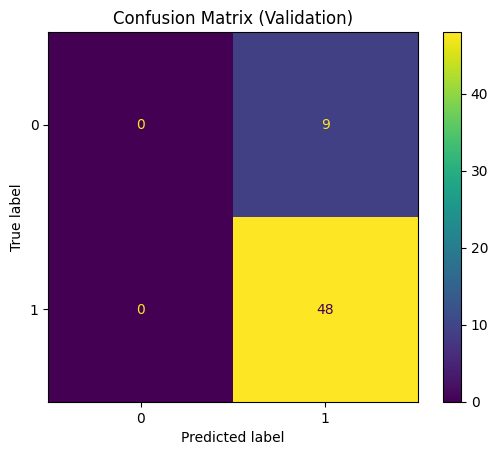

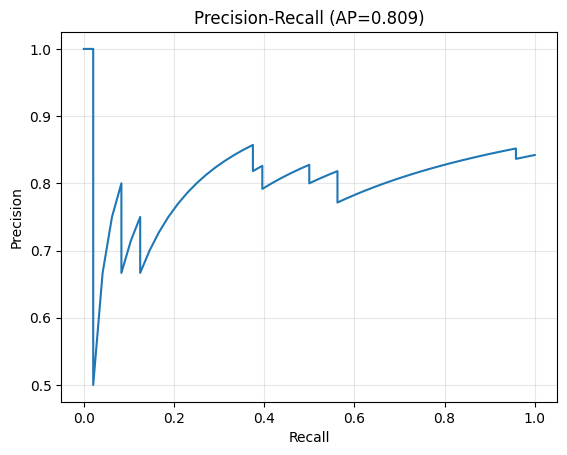

In [12]:

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, precision_recall_curve,
                             average_precision_score)

if pairs is not None:
    feat_cols = ['AvailabilityOverlap', 'AvailabilityScore']
    if 'Capacity' in pairs.columns:
        feat_cols.append('Capacity')
    elif 'SupervisorCapacity' in pairs.columns:
        feat_cols.append('SupervisorCapacity')

    X = pairs[feat_cols]
    y = pairs['Label']
    X_tr, X_va, y_tr, y_va = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000))
    ])
    pipe.fit(X_tr, y_tr)
    accuracy = pipe.score(X_va, y_va)
    print(f'Validation accuracy: {accuracy:.3f}')
    print('Note: synthetic data is heavily positive, so the confusion matrix collapses to a single class.')

    print('=== Validation (zero_division=0) ===')
    print(classification_report(y_va, pipe.predict(X_va), zero_division=0))

    y_pred = pipe.predict(X_va)
    cm = confusion_matrix(y_va, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(values_format='d')
    plt.title('Confusion Matrix (Validation)')
    print(f'Confusion-matrix counts → TN={tn}, FP={fp}, FN={fn}, TP={tp}')
    print('Dark purple cells mean zero pairs; brighter yellow/green highlights larger counts. The lower-right value is the correctly predicted matches (true positives).')
    plt.show()

    y_score = pipe.predict_proba(X_va)[:, 1]
    prec, rec, thr = precision_recall_curve(y_va, y_score)
    ap = average_precision_score(y_va, y_score)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall (AP={ap:.3f})')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print('Pairs not found — run the pipeline cell first.')


### Interpreting the confusion matrix

Colors follow the default viridis scale: dark purple means zero pairs, green/yellow marks higher counts. The lower-right number represents the true positives (correctly predicted matches), and the printed legend under the chart restates each cell so you can narrate results live.


## 3) Capacity-aware greedy assignment

After scoring, we sort pairs by the ML score and walk the list once: assign each associate to the highest-rated supervisor who still has remaining `Capacity`. That greedy pass guarantees we never overbook anyone.


In [13]:

if matches is not None:
    print('Rows:', len(matches))
    if 'assoc_idx' in matches.columns:
        print('Duplicate associate assignments:', matches['assoc_idx'].duplicated().sum())
    else:
        print('assoc_idx missing; skip duplicate check.')
    if 'sup_idx' in matches.columns and 'Capacity' in matches.columns:
        used = matches.groupby('sup_idx').size().rename('assigned')
        cap = matches[['sup_idx','Capacity']].drop_duplicates().set_index('sup_idx')['Capacity']
        cap_check = used.to_frame().join(cap, how='left')
        cap_check['over'] = cap_check['assigned'] - cap_check['Capacity']
        print('Any supervisors over capacity? ->', (cap_check['over']>0).any())
        display(cap_check.head(10))
    else:
        print('sup_idx/Capacity missing; skip capacity check.')
else:
    print('Matches not found.')


Rows: 141
Duplicate associate assignments: 0
Any supervisors over capacity? -> False


,assigned,Capacity,over
sup_idx,,,
0,1,6,-5
2,2,4,-2
3,1,2,-1
4,1,6,-5
5,5,5,0
6,3,4,-1
9,1,5,-4
11,2,3,-1
13,2,2,0


## 4) Peek inside saved model (feature weights)


In [14]:

from joblib import load
import pandas as pd

if model_path.exists():
    bundle = load(model_path)
    model = bundle['model']; feats = bundle['features']
    try:
        coef = model.named_steps['clf'].coef_.ravel()
        display(pd.DataFrame({'feature': feats, 'weight': coef}).sort_values('weight', ascending=False))
    except Exception as e:
        print('Could not read coefficients:', e)
else:
    print('Model not found.')


,feature,weight
2,Capacity,1.082981
0,AvailabilityOverlap,-0.232393
1,AvailabilityScore,-0.288943


## 5) Diagnostics & tuning ideas

Use these outputs to audit the matching pipeline. For confusion matrices as rich as the fruit classifier example, curate a dataset with meaningful negatives or engineered availability features (e.g., binary columns for each day/slot).

- Add tougher negative pairs or class weighting to balance the training data.
- Engineer structured availability features (`Monday 08:00 AM`, `Tuesday 02:30 PM`, …) for more expressive models.
- Replace the greedy assignment with an optimal matcher (Hungarian/ILP) if capacity juggling becomes complex.


## 6) Match outcomes overview

Re-run the cell below after each pipeline execution to refresh totals, highlight top pairings, and show capacity utilization for the demo.


In [15]:

import pandas as pd
from IPython.display import display, Markdown

def _fmt_pct(numer, denom):
    return f"{(numer/denom*100):.1f}%" if denom and denom > 0 else 'n/a'

if matches is not None:
    total_matches = len(matches)
    matched_associates = matches['Associate'].nunique()
    matched_supervisors = matches['Supervisor'].nunique()
    total_associates = len(associates_df) if 'associates_df' in globals() else None
    total_supervisors = len(supervisors_df) if 'supervisors_df' in globals() else None
    unassigned_count = len(unassigned) if unassigned is not None else None

    assoc_pct = _fmt_pct(matched_associates, total_associates) if total_associates else 'n/a'
    sup_pct = _fmt_pct(matched_supervisors, total_supervisors) if total_supervisors else 'n/a'

    headline = (f"Matched {matched_associates} of {total_associates} associates ({assoc_pct})"
                if total_associates else f"Matched associates: {matched_associates}")
    headline_sup = (f"Supervisors engaged: {matched_supervisors} of {total_supervisors} ({sup_pct})"
                    if total_supervisors else f"Supervisors engaged: {matched_supervisors}")
    waiting = (f"Associates still waiting: {unassigned_count}"
               if unassigned_count is not None else 'Associates still waiting: n/a')

    display(Markdown(
        "### Hackathon-ready snapshot"
        f"- {headline}"
        f"- {headline_sup}"
        f"- {waiting}"
        f"- Average final score: {matches['final_score'].mean():.3f}"
        f"- Average availability score: {matches['AvailabilityScore'].mean():.3f}"
    ))

    summary_rows = [
        ('Total matches generated', total_matches),
        ('Associates matched', f"{matched_associates} / {total_associates} ({assoc_pct})" if total_associates else matched_associates),
        ('Supervisors participating', f"{matched_supervisors} / {total_supervisors} ({sup_pct})" if total_supervisors else matched_supervisors),
        ('Associates still unassigned', unassigned_count),
        ('Average final score', f"{matches['final_score'].mean():.3f}"),
        ('Average availability score', f"{matches['AvailabilityScore'].mean():.3f}"),
    ]
    summary_df = pd.DataFrame(summary_rows, columns=['Metric', 'Value'])
    display(summary_df)

    top_matches = (matches[['Associate','Supervisor','Associate State','Supervisor State',
                            'AvailabilityOverlap','AvailabilityScore','final_score']]
                   .sort_values('final_score', ascending=False)
                   .head(10))
    print('Top 10 matches by final score:')
    display(top_matches)

    capacity_usage = (matches.groupby(['Supervisor','Capacity']).size()
                       .rename('Assigned')
                       .reset_index())
    capacity_usage['Remaining'] = capacity_usage['Capacity'] - capacity_usage['Assigned']
    print('Capacity snapshot (next 10 most utilized supervisors):')
    display(capacity_usage.sort_values(['Remaining','Assigned']).head(10))
else:
    print('Matches not found — run the pipeline cell first.')



### Hackathon-ready snapshot- Matched 141 of 200 associates (70.5%)- Supervisors engaged: 71 of 120 (59.2%)- Associates still waiting: 59- Average final score: 0.803- Average availability score: 0.710

,Metric,Value
0,Total matches generated,141
1,Associates matched,141 / 200 (70.5%)
2,Supervisors participating,71 / 120 (59.2%)
3,Associates still unassigned,59
4,Average final score,0.803
5,Average availability score,0.710


Top 10 matches by final score:


,Associate,Supervisor,Associate State,Supervisor State,AvailabilityOverlap,AvailabilityScore,final_score
0,Harper Chen,Alex Bennett,IL,IL,2,0.874573,0.899549
1,Casey Clark,Jordan Ramirez,MN,MN,1,0.838486,0.892037
2,Alex Cooper,Kendall Martinez,"OK, TN, RI",OK,2,0.847485,0.889138
3,Emerson Reed,Sam Nguyen,WV,WV,2,0.835162,0.884321
4,Skyler Rivera,Quinn Hernandez,MN,"RI, MD, MN",1,0.793352,0.873207
5,Peyton Ramirez,Dakota Chen,MA,MA,0,0.782417,0.872969
6,Casey Nguyen,Elliot Chen,FL,FL,1,0.791736,0.872524
7,Finley Lee,Jordan Ramirez,MN,MN,3,0.818111,0.870240
8,Elliot Reed,Alex Bennett,IL,IL,1,0.785196,0.869751
9,Jamie Parker,Kendall Martinez,OK,OK,2,0.794775,0.868200


Capacity snapshot (next 10 most utilized supervisors):


,Supervisor,Capacity,Assigned,Remaining
46,Reese Brooks,2,2,0
51,Reese Martinez,2,2,0
53,Riley Brown,2,2,0
69,Taylor Gonzalez,2,2,0
33,Jordan Brown,3,3,0
65,Skyler Davis,3,3,0
20,Elliot Clark,4,4,0
29,Hayden Moore,5,5,0
62,Sam Hernandez,5,5,0
0,Alex Bennett,6,6,0


## 7) Visualize match coverage

Quick visuals to showcase how capacity is being used and where associates remain unmatched.


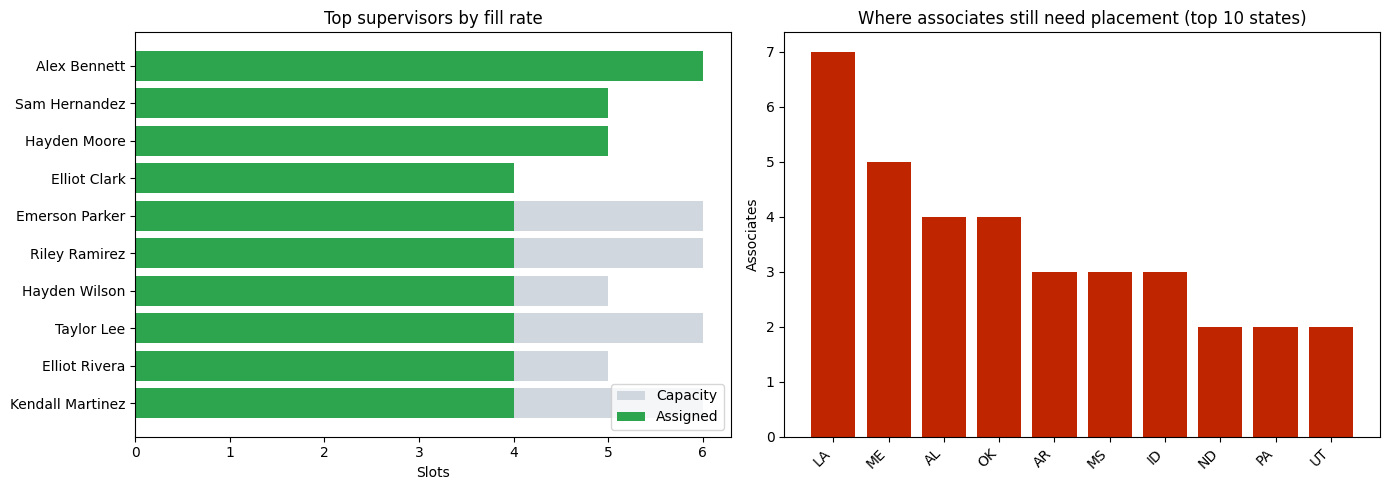

In [16]:

import matplotlib.pyplot as plt
import numpy as np

if matches is not None:
    sup_usage = (matches.groupby(['Supervisor','Capacity']).size()
                 .rename('Assigned')
                 .reset_index())
    sup_usage['Remaining'] = sup_usage['Capacity'] - sup_usage['Assigned']
    top_sup = sup_usage.sort_values('Assigned', ascending=False).head(10)

    def _split_state(value):
        if not isinstance(value, str):
            return []
        parts = [p.strip() for p in value.replace(';',',').split(',') if p.strip()]
        return parts or ['Unknown']

    if unassigned is not None and len(unassigned):
        state_counts = {}
        for s in unassigned['State']:
            for part in _split_state(s):
                state_counts[part] = state_counts.get(part, 0) + 1
        state_df = (pd.Series(state_counts, name='Unassigned')
                     .sort_values(ascending=False)
                     .head(10)
                     .reset_index()
                     .rename(columns={'index':'State'}))
    else:
        state_df = pd.DataFrame({'State':[], 'Unassigned':[]})

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    if not top_sup.empty:
        ax = axes[0]
        y = np.arange(len(top_sup))
        ax.barh(y, top_sup['Capacity'], color='#d0d7de', label='Capacity')
        ax.barh(y, top_sup['Assigned'], color='#2da44e', label='Assigned')
        ax.set_yticks(y)
        ax.set_yticklabels(top_sup['Supervisor'])
        ax.invert_yaxis()
        ax.set_xlabel('Slots')
        ax.set_title('Top supervisors by fill rate')
        ax.legend()
    else:
        axes[0].axis('off')
        axes[0].text(0.5, 0.5, 'No matches yet', ha='center', va='center')

    if not state_df.empty:
        ax = axes[1]
        ax.bar(state_df['State'], state_df['Unassigned'], color='#bf2600')
        ax.set_ylabel('Associates')
        ax.set_title('Where associates still need placement (top 10 states)')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'Everyone matched!', ha='center', va='center')

    plt.tight_layout()
    plt.show()
else:
    print('Matches not found — run the pipeline cell first.')



## 8) Visual roster and drivers

A single dashboard: donut for match coverage, bar chart for why pairs fail, and a color-coded roster so you can tour every associate quickly.


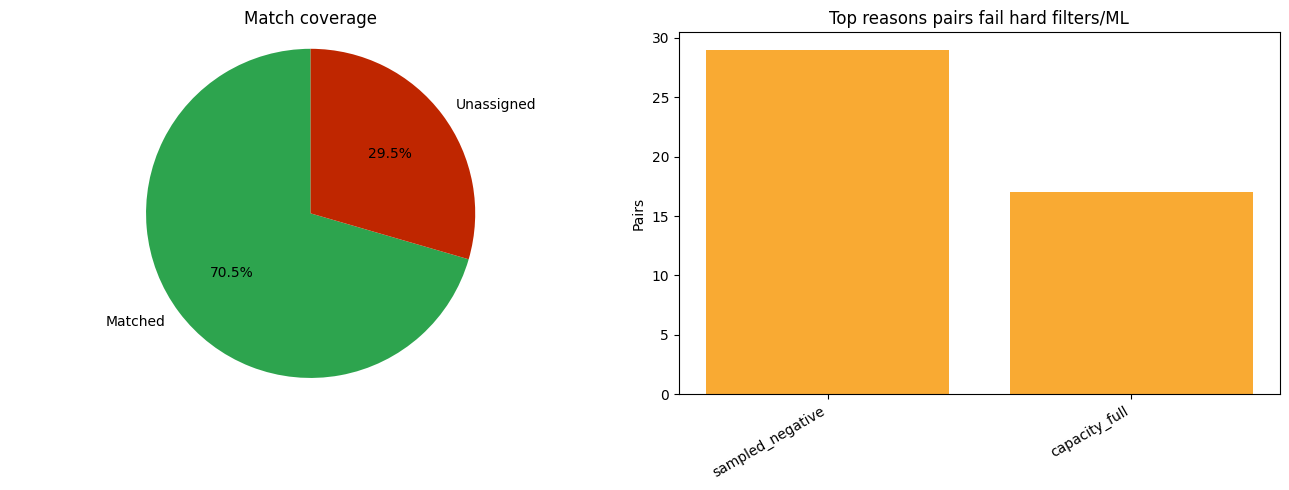

/tmp/ipykernel_87076/1544283327.py:59: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(status_style, subset=['Match Status'])


,Associate,Associate State,Associate License,Match Status,Supervisor,Supervisor State,final_score,AvailabilityScore
0,Dakota Wilson,VA,Social Worker,Matched,Casey Bennett,VA,0.774,0.641
1,Alex Davis,ME,Counselor,Unassigned,—,—,—,—
2,Logan Cooper,MD,Marriage and Family Therapist,Unassigned,—,—,—,—
3,Harper Brooks,AR,Marriage and Family Therapist,Unassigned,—,—,—,—
4,Sam Martinez,IA,Marriage and Family Therapist,Matched,Taylor Lee,IA,0.857,0.837
5,Rowan Garcia,TN,Social Worker,Matched,Reese Brooks,TN,0.689,0.654
6,Avery Hernandez,CA,Counselor,Matched,Emerson Parker,CA,0.813,0.649
7,Taylor Lopez,WI,Psychologist,Matched,Rowan Wilson,WI,0.773,0.579
8,Morgan Patel,MO,Psychologist,Matched,Drew Parker,"MO, NM",0.734,0.623
9,Jamie Bennett,MA,Counselor,Matched,Riley Ramirez,"PA, MA",0.825,0.683


In [17]:

import pandas as pd
import matplotlib.pyplot as plt

if 'associates_df' in globals() and associates_df is not None:
    roster = associates_df.rename(columns={
        'Name': 'Associate',
        'State': 'Associate State',
        'License Type': 'Associate License',
        'Availability': 'Associate Availability'
    }).copy()
    if matches is not None:
        enrich_cols = ['Associate','Supervisor','Supervisor State',
                       'AvailabilityOverlap','AvailabilityScore','final_score']
        roster = roster.merge(matches[enrich_cols], on='Associate', how='left')
    else:
        roster['Supervisor'] = pd.NA
        roster['Supervisor State'] = pd.NA
        roster['AvailabilityOverlap'] = pd.NA
        roster['AvailabilityScore'] = pd.NA
        roster['final_score'] = pd.NA

    roster['Match Status'] = roster['Supervisor'].fillna('').replace('', 'Unassigned')
    roster.loc[roster['Match Status'] != 'Unassigned', 'Match Status'] = 'Matched'

    match_counts = roster['Match Status'].value_counts()
    reasons = None
    if 'pairs' in globals() and pairs is not None:
        reasons = pairs[pairs['Label'] == 0]['Reason'].value_counts().head(6)

    fig, axes = plt.subplots(1, 2, figsize=(13, 5))

    colors = ['#2da44e', '#bf2600']
    axes[0].pie(match_counts, labels=match_counts.index, autopct='%1.1f%%', colors=colors[:len(match_counts)], startangle=90)
    axes[0].set_title('Match coverage')
    axes[0].axis('equal')

    if reasons is not None and not reasons.empty:
        axes[1].bar(reasons.index, reasons.values, color='#f9aa33')
        axes[1].set_title('Top reasons pairs fail hard filters/ML')
        axes[1].set_ylabel('Pairs')
        plt.setp(axes[1].get_xticklabels(), rotation=30, ha='right')
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'No negative pairs in sample', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    roster_view = roster[['Associate','Associate State','Associate License','Match Status','Supervisor','Supervisor State','final_score','AvailabilityScore']]

    def status_style(val):
        if val == 'Matched':
            return 'background-color:#2da44e; color:white'
        if val == 'Unassigned':
            return 'background-color:#bf2600; color:white'
        return ''

    styled = (roster_view.style
              .applymap(status_style, subset=['Match Status'])
              .background_gradient(cmap='Blues', subset=['final_score','AvailabilityScore'])
              .format({'final_score':'{:.3f}','AvailabilityScore':'{:.3f}'}, na_rep='—'))
    display(styled)
else:
    print('Associates dataset not loaded — run the earlier cells first.')

